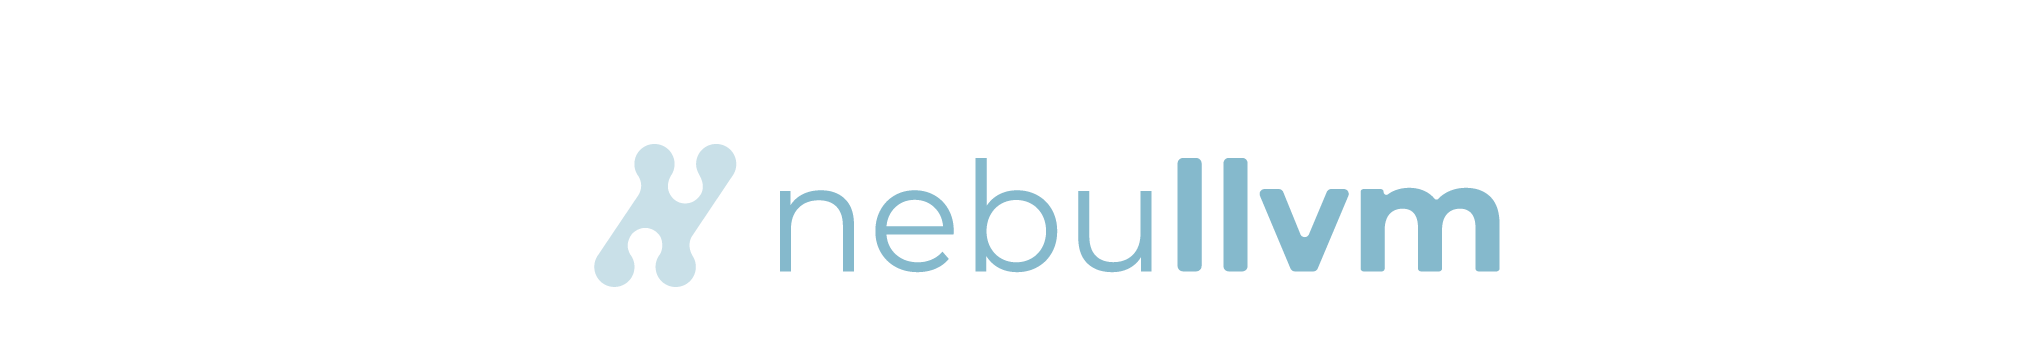

#Accelerate ONNX ResNet50 with nebullvm
Hi and welcome 👋

In this notebook we will discover how in just a few steps you can speed up the response time of deep learning model inference using the open-source library `nebullvm`.

We will
1. Install nebullvm and the deep learning compilers used by the library.
2. Speed up an ONNX ResNet50 without any loss of accuracy.
3. Achieve faster acceleration on the same model by applying more aggressive optimization techniques (e.g. pruning, quantization) under the constraint of sacrificing up to 2% accuracy.

Let's jump to the code.

In [ ]:
%env CUDA_VISIBLE_DEVICES=0

#Installation

In [ ]:
%pip install nebullvm

This is an optional step. Run it if you want to contribute to continuous improvement of `nebullvm` and share the performance achieved with it. You can find full details in the [docs](https://nebuly.gitbook.io/nebuly/nebullvm/how-nebullvm-works/fostering-continuous-improvement#sharing-feedback-to-improve-nebullvm).

In [2]:
json_feedback = {
    "allow_feedback_collection": True
}
import json
from pathlib import Path

(Path.home() / ".nebullvm").mkdir(exist_ok=True)
with open(Path.home() / ".nebullvm/collect.json", "w") as f:
  json.dump(json_feedback, f)

Let's now import nebullvm. During the import we will install the deep learning compilers used by nebullvm that are not yet installed on the hardware.

The installation of the compilers may take a few minutes.

In [ ]:
import nebullvm

# Optimization example with ONNX

In the following example we will try to optimize a standard ONNX resnet50.

Nebullvm can accelerate neural networks without loss of a user-defined precision metric, e.g. accuracy, or can achieve faster acceleration by applying more aggressive optimization techniques, such as pruning and quantization, that may have a negative impact on the selectic metric. The maximum threshold value for accuracy loss is determined by the metric_drop_ths parameter. Read more in the [docs](https://nebuly.gitbook.io/nebuly/nebullvm/get-started).

Let first test the optimization without accuracy loss (metric_drop_ths=0, default value), and then apply further accelerate it under the constrained of losing up to 2% of accuracy (metric = "accuracy", metric_drop_ths = 0.02).

## Scenario 1 - No accuracy drop

First of all we download the pretrained ONNX resnet50 model

In [6]:
!wget https://github.com/onnx/models/raw/main/vision/classification/resnet/model/resnet50-v1-12.onnx

--2022-10-10 19:47:05--  https://github.com/onnx/models/raw/main/vision/classification/resnet/model/resnet50-v1-12.onnx
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/onnx/models/main/vision/classification/resnet/model/resnet50-v1-12.onnx [following]
--2022-10-10 19:47:06--  https://media.githubusercontent.com/media/onnx/models/main/vision/classification/resnet/model/resnet50-v1-12.onnx
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102576593 (98M) [application/octet-stream]
Saving to: ‘resnet50-v1-12.onnx’

resnet50-v1-12.onnx 100%[===================>]  97.82M   259MB/s    in

Then we optimize it with nebullvm simple API

In [ ]:
import numpy as np
from nebullvm.api.functions import optimize_model

# Load a resnet as example
model = "resnet50-v1-12.onnx"

# Provide an input data for the model    
input_data = [((np.random.randn(1, 3, 224, 224).astype(np.float32), ), 0)]

# Run nebullvm optimization
optimized_model = optimize_model(
  model, input_data=input_data, optimization_time="unconstrained"
)

# Try the optimized model
x = np.random.randn(1, 3, 224, 224).astype(np.float32)
res_optimized = optimized_model(x)

We can print the type of the optimized model to see which compiler was faster:

In [8]:
optimized_model

NumpyONNXInferenceLearner(network_parameters=ModelParams(batch_size=1, input_infos=[<nebullvm.base.InputInfo object at 0x7f48206eda10>], output_sizes=[(1000,)], dynamic_info=None), input_tfms=<nebullvm.transformations.base.MultiStageTransformation object at 0x7f480c81a590>)

In our case, the optimized model type was NumpyONNXInferenceLearner, so this means that onnxruntime was the faster compiler.



After the optimization step, we can compare the optimized model with the baseline one in order to verify that the output is the same and to measure the speed improvement

First of all, let's compute and print the original model result



In [17]:
import onnx
import onnxruntime as ort
from typing import Dict, List


def get_input_names(onnx_model: str):
    model = onnx.load(onnx_model)
    input_all = [node.name for node in model.graph.input]
    return input_all


def get_output_names(onnx_model: str):
    model = onnx.load(onnx_model)
    output_all = [node.name for node in model.graph.output]
    return output_all


def run_onnx_model(
    onnx_model: str, session: ort.InferenceSession, input_tensors: List[np.ndarray], inputs: Dict, output_names: str
) -> List[np.ndarray]:
    
    res = session.run(
        output_names=output_names, input_feed=inputs
    )
    return list(res)


session = ort.InferenceSession(
    model,
    providers=["CUDAExecutionProvider", "CPUExecutionProvider"] # Change to ["CPUExecutionProvider"] if run on cpu
)

inputs = {
    name: array
    for name, array in zip(get_input_names(model), [x])
}

res_original = run_onnx_model(model, session, [x], inputs, get_output_names(model))
res_original

[array([[-1.23857968e-01,  1.52007008e+00,  2.68545032e+00,
          1.53301466e+00,  4.11650944e+00,  2.58380914e+00,
          2.01530313e+00,  1.90706924e-01,  3.83482069e-01,
         -1.19363546e+00,  2.57466936e+00,  5.56852198e+00,
          3.07378173e+00,  3.44522691e+00,  4.03184366e+00,
          1.84742117e+00,  5.27928352e-01,  2.39386725e+00,
          3.24960589e+00,  1.89303136e+00, -1.29659843e+00,
          6.64232790e-01,  1.55464339e+00,  1.46186197e+00,
          4.39881086e-02,  3.32891904e-02,  2.25577459e-01,
         -1.59407869e-01,  3.84590328e-01,  3.39020252e-01,
         -1.81147861e+00,  2.41021585e+00, -1.24096537e+00,
          2.06053019e+00,  2.38865709e+00, -1.79495621e+00,
         -2.58589119e-01, -4.36356574e-01,  1.87948334e+00,
          3.85342479e-01,  1.98818159e+00,  5.35687685e-01,
          6.02469087e-01,  5.65175116e-02,  9.72970426e-01,
          4.10859436e-01,  2.69671464e+00, -6.94177628e-01,
         -1.04691410e+00, -4.93430048e-0

Then, let's print the optimized model result that we computed before

In [12]:
res_optimized

(array([[-1.23858564e-01,  1.52006924e+00,  2.68544936e+00,
          1.53301418e+00,  4.11650896e+00,  2.58380795e+00,
          2.01530290e+00,  1.90706745e-01,  3.83481830e-01,
         -1.19363511e+00,  2.57466960e+00,  5.56852245e+00,
          3.07378340e+00,  3.44522715e+00,  4.03184414e+00,
          1.84742033e+00,  5.27928233e-01,  2.39386749e+00,
          3.24960661e+00,  1.89303052e+00, -1.29659903e+00,
          6.64232790e-01,  1.55464351e+00,  1.46186268e+00,
          4.39888835e-02,  3.32886986e-02,  2.25575760e-01,
         -1.59408674e-01,  3.84590447e-01,  3.39019418e-01,
         -1.81147909e+00,  2.41021562e+00, -1.24096644e+00,
          2.06052923e+00,  2.38865662e+00, -1.79495740e+00,
         -2.58589476e-01, -4.36356395e-01,  1.87948370e+00,
          3.85341287e-01,  1.98818219e+00,  5.35688102e-01,
          6.02469325e-01,  5.65172434e-02,  9.72971261e-01,
          4.10859019e-01,  2.69671512e+00, -6.94178581e-01,
         -1.04691458e+00, -4.93430793e-0

Then, let's compute the average latency of the baseline model:



In [18]:
import time

In [20]:
num_iters = 100

# Warmup
for i in range(10):
  run_onnx_model(model, session, [x], inputs, get_output_names(model))

start = time.time()
for i in range(num_iters):
  run_onnx_model(model, session, [x], inputs, get_output_names(model))
stop = time.time()

print("Average latency original model: {:.4f} seconds".format((stop - start) / num_iters))

Average latency original model: 0.0715 seconds


Finally we compute the average latency for the optimized model:

In [21]:
# Warmup
for i in range(10):
  optimized_model(x)

start = time.time()
for i in range(num_iters):
  optimized_model(x)
stop = time.time()

print("Average latency optimized model: {:.4f} seconds".format((stop - start) / num_iters))

Average latency optimized model: 0.0051 seconds


## Scenario 2 - Accuracy drop

In this scenario, we set a max threshold for the accuracy drop to 2%

In [ ]:
import numpy as np
from nebullvm.api.functions import optimize_model

# Load a resnet as example
model = "resnet50-v1-12.onnx"

# Provide an input data for the model
# Note that in this case we should provide the model at least 100 data samples
input_data = [((np.random.randn(1, 3, 224, 224).astype(np.float32), ), 0) for i in range(100)]

# Run nebullvm optimization
optimized_model = optimize_model(
  model, input_data=input_data, optimization_time="unconstrained", metric = "accuracy", metric_drop_ths = 0.02
)

# Try the optimized model
x = np.random.randn(1, 3, 224, 224).astype(np.float32)
res_optimized = optimized_model(x)

Here we compute the average throughput for the baseline model:

In [23]:
num_iters = 100

# Warmup
for i in range(10):
  run_onnx_model(model, session, [x], inputs, get_output_names(model))

start = time.time()
for i in range(num_iters):
  run_onnx_model(model, session, [x], inputs, get_output_names(model))
stop = time.time()

print("Average latency original model: {:.4f} seconds".format((stop - start) / num_iters))

Average latency original model: 0.0763 seconds


Here we compute the average throughput for the optimized model:

In [24]:
# Warmup
for i in range(10):
  optimized_model(x)

start = time.time()
for i in range(num_iters):
  optimized_model(x)
stop = time.time()

print("Average latency optimized model: {:.4f} seconds".format((stop - start) / num_iters))

Average latency optimized model: 0.0048 seconds


<center> 
    <a href="https://discord.com/invite/RbeQMu886J" target="_blank" style="text-decoration: none;"> Join the community </a> |
    <a href="https://nebuly.gitbook.io/nebuly/welcome/questions-and-contributions" target="_blank" style="text-decoration: none;"> Contribute to the library </a>
</center>

<center> 
    <a href="https://github.com/nebuly-ai/nebullvm#how-it-works" target="_blank" style="text-decoration: none;"> How nebullvm works </a> •
    <a href="https://github.com/nebuly-ai/nebullvm#documentation" target="_blank" style="text-decoration: none;"> Documentation </a> •
    <a href="https://github.com/nebuly-ai/nebullvm#api-quick-view" target="_blank" style="text-decoration: none;"> API quick view </a> 
</center>